# Python 2D Navier-stokes simulation

Taken from Lorena Barba

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [55]:
nx = 20
ny = 20

start_time = 0
end_time = 5
dt = 0.005
write_interval = 20
output_inc = dt * write_interval
num_outputs = ( end_time / output_inc ) + 1

nt = len(np.arange(start_time,end_time + dt,dt))
print(nt)
nit = 50

#c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)

rho = 1
nu = 0.01

1001


In [56]:
def build_up_b(b, rho, dt, u, v, dx, dy):
    
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))

    return b

In [57]:
def pressure_poisson(p, dx, dy, b):
    pn = np.empty_like(p)
    pn = p.copy()
    
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

        p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
        p[-1, :] = 0        # p = 0 at y = 2
        
    return p

In [58]:
def cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu):
    write_index = 0
    un = np.empty_like(u)
    vn = np.empty_like(v)
    b = np.zeros((ny, nx))
    
    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        
        b = build_up_b(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson(p, dx, dy, b)
        
        if n % write_interval == 0:
            #print(f"Write index {write_index} output at timestep {n}")
            p_full[:,:,write_index] = p
        
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = 1    # set velocity on cavity lid equal to 1
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0
        
        if n % write_interval == 0:
            u_full[:,:,write_index] = u
            v_full[:,:,write_index] = v
            write_index += 1

    return u, v, p

In [59]:
u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))
b = np.zeros((ny, nx))

u_full = np.zeros((ny, nx, int(num_outputs)))
v_full = np.zeros((ny, nx, int(num_outputs)))
p_full = np.zeros((ny, nx, int(num_outputs)))

u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

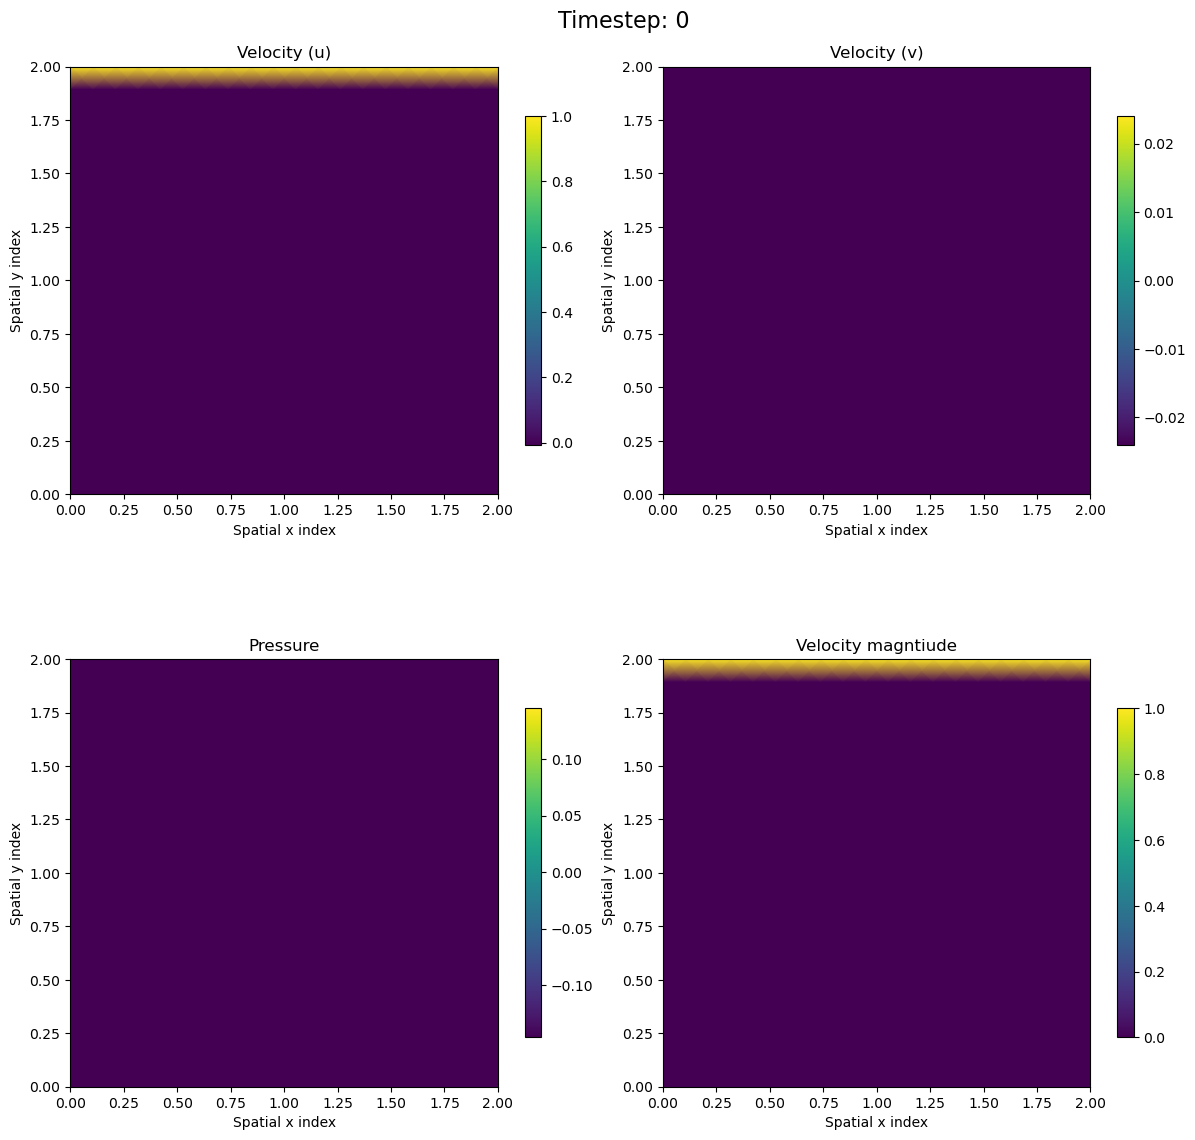

In [60]:
#Takes about 1.5 minutes to compute

fig, ax = plt.subplots(2,2, figsize=(12, 12))
fig.tight_layout()
fig.colorbar(ax[0][0].pcolormesh(X, Y, u_full[:,:,int(1)], shading='gouraud'), shrink=0.6, orientation='vertical')
fig.colorbar(ax[0][1].pcolormesh(X, Y, v_full[:,:,int(1)], shading='gouraud'), shrink=0.6, orientation='vertical')
fig.colorbar(ax[1][0].pcolormesh(X, Y, p_full[:,:,int(1)], shading='gouraud'), shrink=0.6, orientation='vertical')
fig.colorbar(ax[1][1].pcolormesh(X, Y, np.sqrt(u_full[:,:,-1]**2 + v_full[:,:,-1]**2), shading='gouraud'), shrink=0.6, orientation='vertical')

u_mag_full = np.sqrt(u_full.astype(np.double)**2 + v_full.astype(np.double)**2).astype(float)

def animate_subplot(i):
    fig.suptitle(f"Timestep: {i*write_interval}", fontsize=16)
    ax[0][0].pcolormesh(X, Y, u_full[:,:,int(i)], shading='gouraud')
    if i != 0:
        ax[0][0].quiver(X,Y,u_full[:,:,int(i)],v_full[:,:,int(i)])
    ax[0][0].set_title("Velocity (u)")
    ax[0][0].set_ylabel("Spatial y index")
    ax[0][0].set_xlabel("Spatial x index")
    ax[0][0].set_box_aspect(1)

    ax[0][1].pcolormesh(X, Y, v_full[:,:,int(i)], shading='gouraud')
    if i != 0:
        ax[0][1].quiver(X,Y,u_full[:,:,int(i)],v_full[:,:,int(i)])
    ax[0][1].set_title("Velocity (v)")
    ax[0][1].set_ylabel("Spatial y index")
    ax[0][1].set_xlabel("Spatial x index")
    ax[0][1].set_box_aspect(1)

    ax[1][0].pcolormesh(X, Y, p_full[:,:,int(i)], shading='gouraud')
    if i != 0:
        ax[1][0].quiver(X,Y,u_full[:,:,int(i)],v_full[:,:,int(i)])
    ax[1][0].set_title("Pressure")
    ax[1][0].set_ylabel("Spatial y index")
    ax[1][0].set_xlabel("Spatial x index")
    ax[1][0].set_box_aspect(1)

    ax[1][1].pcolormesh(X, Y, u_mag_full[:,:,int(i)], shading='gouraud')
    if i != 0:
        ax[1][1].quiver(X,Y,u_full[:,:,int(i)],v_full[:,:,int(i)])
    ax[1][1].set_title("Velocity magntiude")
    ax[1][1].set_ylabel("Spatial y index")
    ax[1][1].set_xlabel("Spatial x index")
    ax[1][1].set_box_aspect(1)

ani = animation.FuncAnimation(fig, animate_subplot, int(num_outputs), interval=1)
ani.save('full_python.gif')